<a name='introduction'></a>
# Проект "Прогнозирование температуры звезды"

Предоставлен набор данных о звездах. Имеются следующие их 6 характеристик:
- **Temperature (K)**. Абсолютная температура в Кельвинах. ***Целевой показатель***;
- **Luminosity(L/Lo)**. Светимость звезды относительно Солнца;
- **Radius(R/Ro)**. Радиус звезды относительно радиуса Солнца;
- **Absolute magnitude(Mv)**. Физическая величина, характеризующая блеск звезды;
- **Star color**. Цвет звезды, определяемый на основе спектрального анализа;
- **Star type**. Тип звезды.

<br>**Типы звезд** (параметр *Star type*):
- 0 - Коричневый карлик;
- 1 - Красный карлик;
- 2 - Белый карлик;
- 3 - Звезды главной последовательности;
- 4 - Сверхгигант;
- 5 - Гипергигант.

<br>В рамках данного проекта необходимо предсказать абсолютную температуру на поверхности звезды в Кельвинах. Существуют различные способы определения абсолютной температуры на поверхности звезды, но заказчик, Обсерватори, надеется, что технологии машинного обучения помогут определить температуру точнее.

<br>**План работы**:
1. [Импортирование библиотек и файлов](#import)
2. [Предобработка и анализ данных](#preprocessing)
    - [Общие характеристики](#general)
    - [Предобработка отдельных параметров](#parameters)
        - [color](#color)
        - [type](#type)
    - [Исследовательский анализ анализ данных](#eda)
        - [Корреляция светимости звезд от их температуры](#l_t_ratio)
        - [Корреляция типа звезды и температуры](#t_t_ratio)
        - [Корреляция между цветом звезды и температурой](#c_t_ratio)
        - [Корреляция между радиусом звезды и температурой](#r_t_ratio)
        - [Корреляция между абсолютной звездной величиной и температурой ](#m_t_ratio)
        - [Корреляция между абсолютной звездной величиной и типом](#mv_t_ratio)
    - [Корреляция phik](#phik_corr)
    - [Заключения по исследовательскому анализу данных](#eda_conclusions)
3. [Подготовка данных к построению модели](#data_preparation)
4. [Построение базовой нейронной сети](#nn_creation)
    - [Инициализация необходимых функций](#necessary_functions)
    - [Создание базовой нейронной сети](#basic_nn)
5. [Улучшение нейронной сети](#nn_improvement)
    - [Использование батчей](#batch_usage)
    - [Batch Normalization](#batch_norm)
    - [Dropout](#dropout)
6. [Выводы](#conclusion)

<a name='import'></a>
## 1.  Импортирование библиотек и файлов
[Введение](#introduction)

In [1]:
%pip install phik
%pip install numpy --upgrade

from math import ceil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn

import phik
from phik import report
from phik.report import plot_correlation_matrix

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

     |████████████████████████████████| 679 kB 990 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 17.7 MB 12.8 MB/s eta 0:00:01   |█████████████████               | 9.3 MB 1.1 MB/s eta 0:00:08
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.1
    Uninstalling numpy-1.21.1:
      Successfully uninstalled numpy-1.21.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.9.1 requires numpy<1.25.0,>=1.18.5, but you have numpy 1.25.0 which is incompatible.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 1.25.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df_stars = pd.read_csv('/datasets/6_class.csv', index_col=0)
df_stars.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


<a name='preprocessing'></a>
## 2. Предобработка и анализ данных
[Введение](#introduction)

<br>План предобработки и анализа данных:
1. [Общие характеристики](#general)
2. [Предобработка отдельных параметров](#parameters)
3. [Исследовательский анализ анализ данных](#eda)
4. [Корреляция phik](#phik_corr)

<a name='general'></a>
### 2. 1. Общие характеристики
[Введение](#introduction)

In [3]:
print('Характеристики объектов:', df_stars.columns.values)
print('\nРазмер выборки:', df_stars.shape)

Характеристики объектов: ['Temperature (K)' 'Luminosity(L/Lo)' 'Radius(R/Ro)'
 'Absolute magnitude(Mv)' 'Star type' 'Star color']

Размер выборки: (240, 6)


In [4]:
# Пропущенные значения
df_stars.isna().sum()

Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
dtype: int64

In [5]:
# Рассмотрим разброс значений
df_stars.describe()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


In [6]:
# Изменим имеющиеся названия столбцов путем упрощения
df_stars.columns = ['temp', 'luminosity', 'radius', 'magnitude', 'type', 'color']

<a name='parameters'></a>
### 2. 2. Предобработка отдельных параметров
[Введение](#introduction)

<a name='color'></a>
#### 2. 2. 1. color

In [7]:
print("Уникальные значения параметра 'color' ДО предобработки:")
df_stars['color'].unique()

Уникальные значения параметра 'color' ДО предобработки:


array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

Заметно, что многие уникальные значения по сути идентичны, но различаются по написанию. Приведем их к единому виду: если предполагается наличие двух цветов, то они будут отображаться через пробел с заглавных букв - "Blue White". Значения по типу "whitish", "yellowish" и т. д. поменяем на "white", "yellow" и другие соответственно.

In [8]:
# Blue
df_stars.loc[
    df_stars['color'] == 'Blue ',
    'color'
] = 'Blue'

# Blue and white
df_stars.loc[
    (df_stars['color'] == 'Blue white') | 
    (df_stars['color'] == 'Blue-white') |
    (df_stars['color'] == 'Blue-White') |
    (df_stars['color'] == 'Blue white '), 
    'color'
] = 'Blue White'

# White
df_stars.loc[
    (df_stars['color'] == 'white'),
    'color'
] = 'White'

# Whitish
df_stars.loc[
    (df_stars['color'] == 'whitish'),
    'color'
] = 'Whitish'

# Yellowish
df_stars.loc[
    (df_stars['color'] == 'yellowish'),
    'color'
] = 'Yellowish'

# Yellow and white
df_stars.loc[
    (df_stars['color'] == 'Yellowish White') |
    (df_stars['color'] == 'yellow-white') | 
    (df_stars['color'] == 'White-Yellow'),
    'color'
] = 'Yellow White'

# Yellow and orange
df_stars.loc[
    df_stars['color'] == 'Pale yellow orange',
    'color'
] = 'Yellow Orange'

# Orange and red
df_stars.loc[
    df_stars['color'] == 'Orange-Red',
    'color'
] = 'Orange Red'

In [9]:
print('Уникальные значения параметры "color" после предобработки:')
df_stars['color'].unique()

Уникальные значения параметры "color" после предобработки:


array(['Red', 'Blue White', 'White', 'Yellow White', 'Yellow Orange',
       'Blue', 'Whitish', 'Orange', 'Yellowish', 'Orange Red'],
      dtype=object)

<a name='type'></a>
#### 2. 2. 2. type

In [10]:
# Уникальные значения параметра 'type'
df_stars['type'].unique()

array([0, 1, 2, 3, 4, 5])

In [11]:
# Посмотрим распределение типов звезд
df_stars['type'].value_counts()

0    40
1    40
2    40
3    40
4    40
5    40
Name: type, dtype: int64

По параметру 'type' аномальных значений выявлено не было.

<a name='eda'></a>
### 2. 3. Исследовательский анализ анализ данных
[Введение](#introduction)

<br>Найдем корреляцию между следующими параметрами:
1. [Корреляция светимости звезд от их температуры](#l_t_ratio)
2. [Корреляция типа звезды и температуры](#t_t_ratio)
3. [Корреляция между цветом звезды и температурой](#c_t_ratio)
4. [Корреляция между радиусом звезды и температурой](#r_t_ratio)
5. [Корреляция между абсолютной звездной величиной и температурой](#m_t_ratio)
6. [Корреляция между абсолютной звездной величиной и типом](#mv_t_ratio)

In [12]:
# Функция для создания диаграммы разброса
def create_scatter_plot(x, y, xname, yname, color, logx=False, logy=False, x_rotation=0):
    df_stars.plot(
        x=x,
        y=y,
        color=color,
        figsize=(7, 7),
        fontsize=12,
        grid=True,
        kind='scatter',
        logx=logx,
        logy=logy
    )

    plt.title(f'Корреляция между "{xname}" и "{yname}"', fontsize=16)
    plt.xlabel(f'{xname}', fontsize=14)
    plt.ylabel(f'{yname}', fontsize=14)
    plt.xticks(rotation=x_rotation)
    plt.show()

<a name='l_t_ratio'></a>
#### 2. 3. 1. Корреляция светимости звезд от их температуры
[Введение](#introduction)

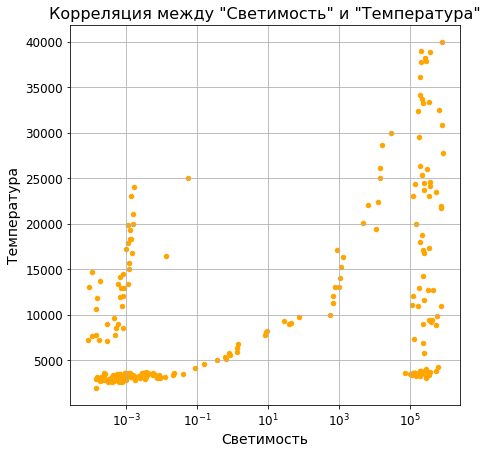

In [13]:
create_scatter_plot(
    x='luminosity',
    y='temp',
    xname='Светимость',
    yname='Температура',
    color='orange',
    logx=True
)

На графике можно заметить разделение объектов на 3 части: 1) температура находится в районе 10^(-3) и менее, а разброс светимости - от 7 500 до 25 000; 2) начинается слева снизу и идет по впуклой парабале направо наверх; 3) Температура превышает 10^(5), а диапазон светимости - от 4000 до 40 000.

Ввиду этого прослеживается некая связь между светимостью и температурой, однако, вероятно, это зависит и от других параметров, учитывая разделение графика на 3 части.

<a name='t_t_ratio'></a>
#### 2. 3. 2. Корреляция типа звезды и температуры
[Введение](#introduction)

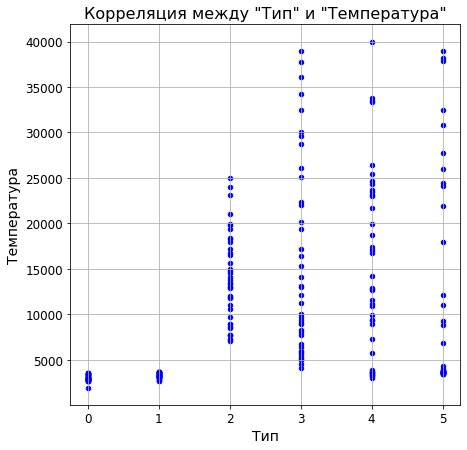

In [14]:
create_scatter_plot(
    x='type', 
    y='temp',
    xname='Тип',
    yname='Температура',
    color='blue'
)

Согласно графику для типов звезд 0 и 1 температура менее 5 000 Кельвинов. Для второго типа она находится в диапазоне от 7 500 до 25 000 Кельвинов, а для остальных типов варьируется в диапазоне от менее 5 000 Кельвинов и до 40 000. Тем не менее, по крайне мере для первых трех типов звезд: "Коричневых", "Красных" и "Белых" карликов - видна корреляция между их типом и температурой.

<a name='c_t_ratio'></a>
#### 2. 3. 3. Корреляция между цветом звезды и температурой
[Введение](#introduction)

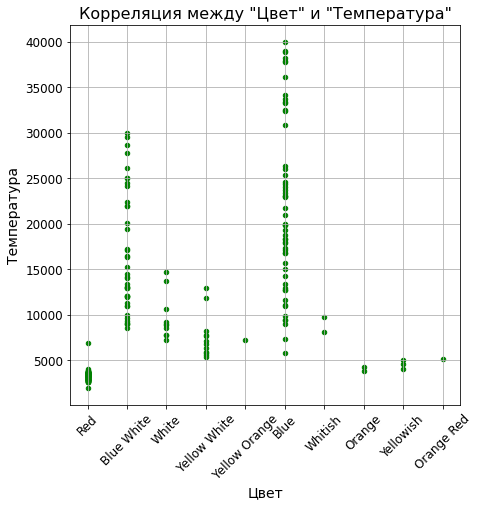

In [15]:
create_scatter_plot(
    x='color',
    y='temp',
    xname='Цвет',
    yname='Температура',
    color='green',
    x_rotation=45
)

In [16]:
# Количество звезд по цвету
df_stars['color'].value_counts()

Red              112
Blue              56
Blue White        41
Yellow White      12
White             10
Yellowish          3
Orange             2
Whitish            2
Yellow Orange      1
Orange Red         1
Name: color, dtype: int64

В значительной степени зависит температура звезды от ее цвета. Так, наименьший разброс в температурах между звездами таких цветов, как: красный, оранжево-красный, оранжевый, желтый, желто-оранжевый, желто-белый и белый. Однако, в этом плане необходимо учитывать их количество в выборке. Крайне маленькая выборка приходится на звезды желтого, оранжевого, оранжево-красного и желто-оранжевого цветов (не более 3). 

Ввиду этого, можно скорее проследить корреляцию между теми звездами, цвета которых больше представлены в выборке, и температура которых не сильно варьируется. К таким можно отнести: 
- Красный (112 объектов). Температура: от около 2 500 до 7 500;
- Белый (12 объектов). Температура: от около 7 500 до 15 000;
- Желто-белый (12 объектов). Температура: от 5 000 до примерно 13 000.

<a name='r_t_ratio'></a>
#### 2. 3. 4. Корреляция между радиусом звезды и температурой
[Введение](#introduction)

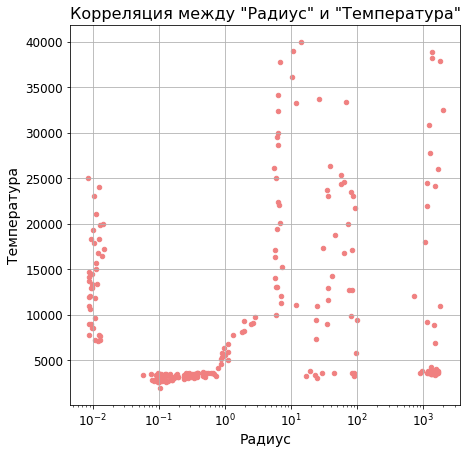

In [17]:
create_scatter_plot(
    x='radius',
    y='temp',
    xname='Радиус',
    yname='Температура',
    color='lightcoral',
    logx=True
)

В соответствии с графиком можно заметить, что корреляция между радиусом звезды и ее температурой не столь четко прослеживается. Однако, звезды, чей радиус находится в районе от 0.1 до 1 (относительно радиуса Солнца), имеют примерно одинаковую температуру в районе около 3 500 - 4 000 Кельвинов. В остальных же случаях наблюдается сильный разброс значений.

<a name='m_t_ratio'></a>
#### 2. 3. 5. Корреляция между абсолютной звездной величиной и температурой 
[Введение](#introduction)

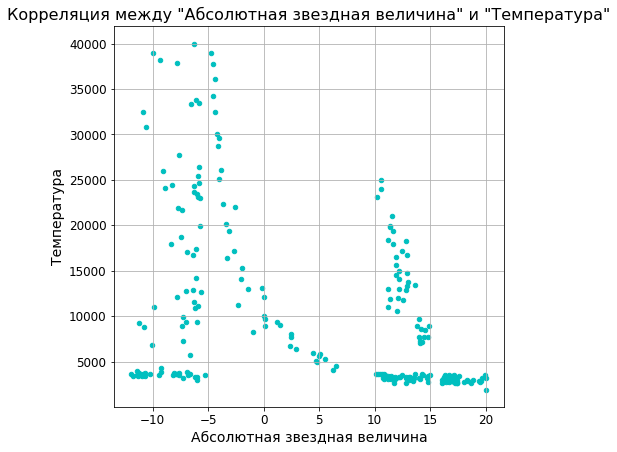

In [18]:
create_scatter_plot(
    x='magnitude',
    y='temp',
    xname='Абсолютная звездная величина',
    yname='Температура',
    color='c'
)

Заметно, что есть разброс объектов, температура которых не превышает и 5 000 Кельвинов, но абсолютная звездная величина (блеск) разнится от менее -10 до 20. Также виден график ветви параболы в промежутке от -5 до 10 абсолютной звездной величины.

<a name='mv_t_ratio'></a>
#### 2. 3. 6. Корреляция между абсолютной звездной величиной и типом
[Введение](#introduction)

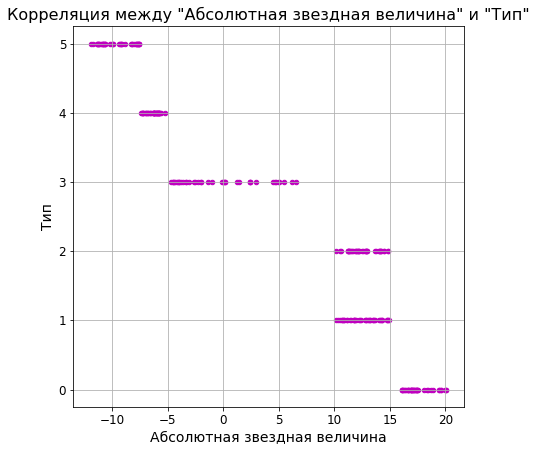

In [19]:
create_scatter_plot(
    x='magnitude',
    y='type',
    xname='Абсолютная звездная величина',
    yname='Тип',
    color='m'
)

Отчетлива видна корреляция между типом звезды и ее абсолютной звездной величной. Получается, что во многих случаях блеск звезды коррелирует с ее типом, но это не относится к 1 и 2 типам - Красным и белым карликам, - значения абсолютной звездной величины которых находятся в районе от 10 до 15.

<a name='phik_corr'></a>
### 2. 4. Корреляция phik
[Введение](#introduction)

interval columns not set, guessing: ['temp', 'luminosity', 'radius', 'magnitude', 'type']


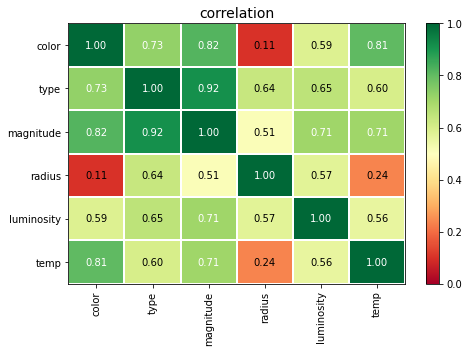

In [20]:
phik_overview = df_stars.phik_matrix()
phik_overview.round(2)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0,
    vmax=1
)

Примечательно, что заметно довольно высокие корреляции между отдельными параметрами. Более того, низкая корреляция - это скорее исключение. Наибольшая корреляция наблюдается между типом звезды и ее абсолютной звездной величиной - 0.92. С целевым показателем наибольшая взаимосвязь наблюдается также с абсолютной звездной величиной и цветом звезды: 0.71 и 0.68 соответственно. С типом звезды и светимостью - 0.60 и 0.56 соответственно. Можно сделать вывод, что меньше всего температура зависит от радиуса, т. к. коэффициент корреляции составляет 0.24, однако он не равен нулю, поэтому об отсутствии полной взаимосвязи речи не идет.

<a name='eda_conclusions'></a>
### 2. 5. Заключения по исследовательскому анализу данных
[Введение](#introduction)

На основании проведенного исследовательского анализа данных можно сделать несколько выводов:
1. **Светимость и температура**. Наблюдается небольшая корреляция. Объекты разделены на 3 части на графике, поэтому можно заключить, что температура звезды также зависит и от других параметров;
2. **Тип звезды и температура**. Коричневые и красные карлики - < 5 000 Кельвинов, Белые карлики - от 7 500 до 25 000, иные типы - значения температур значительно варьируются;
3. **Цвет звезды и температура**. Наблюдается небольшая степень взаимозависимости. Красный цвет: от 2 500 до 7 500 Кельвинов; Белый: 7 500 - 15 000; Желто-белый: 5 000 - 13 000. Для таких цветов, как: оранжевый, желтый, оранжево-красный, желто-оранжевый количество объектов недостаточно для определения закономерности; 
4. **Радиус звезды и температура**. Не столь сильная корреляция. Примерно одинаковая температура для звезд, чей радиус находится в диапазоне от 0.1 до 1: 3 500 - 4 000 Кельвинов.
5. **Абсолютная звездная величина и температура**. Не прослеживается четкой закономерности, но видна ветвь параболы на графике в диапазоне от -5 до 10 абсолютной звездной величины;
6. **Абсолютная звездная величина и тип звезды**. Четкая корреляция, кроме красных и белых карликов - значения абсолютной звездной величины находятся в диапазоне от 10 до 15;
7. **Общая корреляция между параметрами (phik)**. Наибольший коэффициент корреляции - абсолютная звездная величина и тип звезды: 0.92. Наибольшая взаимосвязь с температурой: абсолютная звездная величина и цвет - 0.71 и 0.68 соответственно. С типом и светимостью - 0.60 и 0.56 соответственно. Радиус - 0.24.

<a name='data_preparation'></a>
## 3. Подготовка данных к построению модели
[Введение](#introduction)

In [21]:
pd.options.mode.chained_assignment = None

numeric_cols = ['luminosity', 'radius', 'magnitude']
categorical_cols = ['color', 'type']

# Разбиение данных на независимые и целевую переменные
X = df_stars.drop('temp', axis=1)
y = df_stars['temp']

X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Разбиение объектов на тренировочну и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.25
)

scaler = StandardScaler()
scaler.fit(X_train[numeric_cols])

X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

<a name='nn_creation'></a>
## 4. Построение базовой нейронной сети
[Введение](#introduction)

<br>План данной главы работы:
1. [Инициализация необходимых функций](#necessary_functions)
2. [Создание базовой нейронной сети](#basic_nn)

<a name='necessary_functions'></a>
### 4. 1. Инициализация необходимых функций
[Введение](#introduction)

Первоначально определим функции для:
1. Обучения модели без использования батчей;
2. Обучения модели с использованием батчей;
3. Тестирования модели;
4. Создания графика с отображением спрогнозированных и действительных значений температур звезд.

In [22]:
# Функция обучения модели
def model_training(train_x, train_y):
    optimizer.zero_grad()
    preds = net.forward(train_x).flatten()
    
    # L2-Регуляризация весов
    l2_lambda = 0.001
    l2_norm = sum(p.pow(2.0).sum() for p in net.parameters())
    loss_value = torch.sqrt(loss(preds, train_y)) + l2_lambda * l2_norm
    loss_value.backward()

    optimizer.step()

In [23]:
# Функция тестирования модели
def model_testing(epoch):
    net.eval()
    test_preds = net.forward(X_test).flatten()
    print('Epoch #:', epoch)
    print('RMSE =', torch.sqrt(loss(test_preds, y_test)).item(), '\n')
    return test_preds

In [24]:
# Функция для обучения с использованием батчей
def batch_training(epochs_num, epoch_test):
    batch_size = 100
    num_batches = ceil(len(X_train) / batch_size)

    for epoch in range(epochs_num):
        order = np.random.permutation(len(X_train))
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            
            optimizer.zero_grad()

            batch_indexes = order[start_idx:start_idx + batch_size]
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]

            model_training(X_batch, y_batch)
        if epoch % epoch_test == 0:
            y_pred = model_testing(epoch)
    return y_pred

In [41]:
# Функция для отображения графика "Факт-Прогноз"
def show_graph(y_pred):
    start = 0
    end = 15
    
    basic_df = y_test[start:end]
    nn_df = y_pred[start:end]

    plt.figure(figsize=(7, 7))
    plt.bar(range(start, end), nn_df.detach().numpy(), color='orange', label='Прогноз')
    plt.bar(range(start, end), basic_df, color='blue', width=0.5, label='Факт')

    plt.legend()
    plt.title('Факт-Прогноз', fontsize=16)
    plt.xlabel('Номер звезды в таблице данных', fontsize=14)
    plt.ylabel('Температура звезды', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

<a name='basic_nn'></a>
### 4. 2. Создание базовой нейронной сети
[Введение](#introduction)

In [37]:
# Количество нейронов на каждом слое
in_neurons = X_train.shape[1]
hidden_neurons_1 = 8
hidden_neurons_2 = 5
out_neurons = 1

# Создание класса нейронной сети с 3 скрытыми слоями
class NeuralNet(nn.Module):
    def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
        self.ac1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
        self.ac2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(hidden_neurons_2, out_neurons)
        self.ac3 = nn.LeakyReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        return x


# Инициализация нейросети
net = NeuralNet(in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons)

In [38]:
# Функция для инициализации весов
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.kaiming_uniform_(
            layer.weight,
            mode='fan_in',
            nonlinearity='relu'
        )

# Инициализация весов нейросети
net.apply(init_weights)

NeuralNet(
  (fc1): Linear(in_features=17, out_features=8, bias=True)
  (ac1): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=8, out_features=5, bias=True)
  (ac2): LeakyReLU(negative_slope=0.01)
  (fc3): Linear(in_features=5, out_features=1, bias=True)
  (ac3): LeakyReLU(negative_slope=0.01)
)

In [39]:
# Создание оптимизатора и функции потерь
optimizer = torch.optim.Adam(net.parameters(), lr=2e-3)
loss = nn.MSELoss()

# Обучение нейросети
num_epochs = 8001

for epoch in range(num_epochs):
    model_training(X_train, y_train)
    if epoch % 1000 == 0:
        basic_nn_preds = model_testing(epoch)

Epoch #: 0
RMSE = 14626.58984375 

Epoch #: 1000
RMSE = 11748.98828125 

Epoch #: 2000
RMSE = 7665.7822265625 

Epoch #: 3000
RMSE = 6787.57470703125 

Epoch #: 4000
RMSE = 5737.6708984375 

Epoch #: 5000
RMSE = 4887.11962890625 

Epoch #: 6000
RMSE = 4319.08349609375 

Epoch #: 7000
RMSE = 4321.9794921875 

Epoch #: 8000
RMSE = 4342.12939453125 



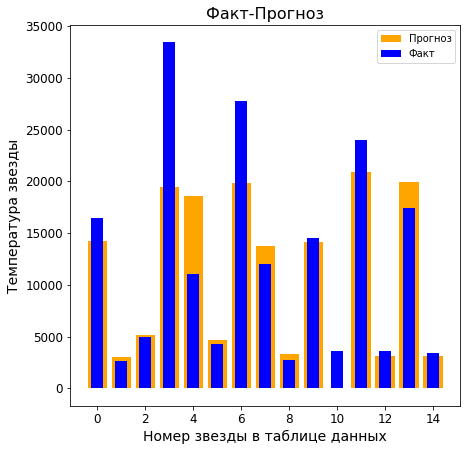

In [42]:
# Создание графика "Факт-Прогноз" по полученным результатам нейросети
show_graph(basic_nn_preds)

Метрика RMSE достигла значения около 4 350. В данном случае необходимый порог в 4 500 пройден.

Параметры модели на данном этапе:
- Общее количество эпох - 8 001;
- Тестирование модели - каждые 1 000.

<a name='nn_improvement'></a>
## 5. Улучшение нейронной сети
[Введение](#introduction)

<br>Для улучшений нейросети воспользуется различными способами, которые смогут повысить окончательную метрику качества нейросети - RMSE.

<br><b>Улучшения нейросети:</b>
1. [Использование батчей](#batch_usage)
2. [Batch Normalization](#batch_norm)
3. [Dropout](#dropout)

<a name='batch_usage'></a>
### 5. 1. Использование батчей
[Введение](#introduction)

In [43]:
# Создание класса нейронной сети с 3 скрытыми слоями
class ImprovedNeuralNet(nn.Module):
    def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons):
        super(ImprovedNeuralNet, self).__init__()
        self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
        self.ac1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
        self.ac2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(hidden_neurons_2, out_neurons)
        self.ac3 = nn.LeakyReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        return x


# Инициализация сети и весов для нее
net = ImprovedNeuralNet(in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons)
net.apply(init_weights)

# Новая инициализация оптимизатора (поскольку используется новая модель)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# Тренировка и тестирование нейросети с использованием батчей
batch_nn_preds = batch_training(epochs_num=15001, epoch_test=1000)

Epoch #: 0
RMSE = 14626.859375 

Epoch #: 1000
RMSE = 13526.859375 

Epoch #: 2000
RMSE = 9886.087890625 

Epoch #: 3000
RMSE = 7924.13818359375 

Epoch #: 4000
RMSE = 7343.56494140625 

Epoch #: 5000
RMSE = 7018.84130859375 

Epoch #: 6000
RMSE = 6714.3876953125 

Epoch #: 7000
RMSE = 6331.84130859375 

Epoch #: 8000
RMSE = 5862.89404296875 

Epoch #: 9000
RMSE = 5448.78759765625 

Epoch #: 10000
RMSE = 5182.4111328125 

Epoch #: 11000
RMSE = 4960.27294921875 

Epoch #: 12000
RMSE = 4937.82080078125 

Epoch #: 13000
RMSE = 4952.43212890625 

Epoch #: 14000
RMSE = 4963.91748046875 

Epoch #: 15000
RMSE = 4966.23779296875 



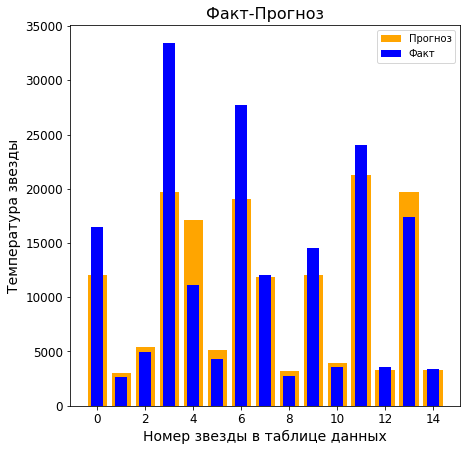

In [44]:
# Создание графика "Факт-Прогноз" по полученным результатам нейросети
show_graph(batch_nn_preds)

Удалось достичь значения показателя RMSE около 5 000.

Параметры модели на данном этапе:
- Использование батчей при обучении;
- Общее количество эпох - 15 001;
- Тестирование модели - каждые 1 000.

<a name='batch_norm'></a>
### 5. 2. Batch Normalization
[Введение](#introduction)

In [45]:
#  Создание улучшенной нейросети с нормализацией батчей
class BatchImprovedNeuralNet(nn.Module):
    def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons):
        super(BatchImprovedNeuralNet, self).__init__()
        self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
        self.batch1 = nn.BatchNorm1d(hidden_neurons_1)
        self.ac1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
        self.batch2 = nn.BatchNorm1d(hidden_neurons_2)
        self.ac2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(hidden_neurons_2, out_neurons)
        self.batch3 = nn.BatchNorm1d(out_neurons)
        self.ac3 = nn.LeakyReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.batch1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.batch2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.batch3(x)
        x = self.ac3(x)
        return x


# Инициализация модели, весов и оптимизатора
net = BatchImprovedNeuralNet(in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons)
net.apply(init_weights)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# Релизация обучения с помощью батчей
batch_norm_nn_preds = batch_training(epochs_num=5001, epoch_test=500)

Epoch #: 0
RMSE = 14626.81640625 

Epoch #: 500
RMSE = 9370.6005859375 

Epoch #: 1000
RMSE = 6826.3154296875 

Epoch #: 1500
RMSE = 5145.97314453125 

Epoch #: 2000
RMSE = 4317.91015625 

Epoch #: 2500
RMSE = 4204.10546875 

Epoch #: 3000
RMSE = 4115.41455078125 

Epoch #: 3500
RMSE = 4096.81982421875 

Epoch #: 4000
RMSE = 4062.719482421875 

Epoch #: 4500
RMSE = 4047.102294921875 

Epoch #: 5000
RMSE = 4053.055908203125 



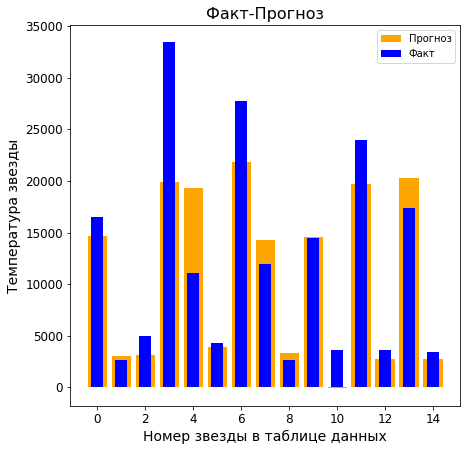

In [46]:
# Создание графика "Факт-Прогноз" по полученным результатам нейросети
show_graph(batch_norm_nn_preds)

Модель достигла значения около 4 000, пройдя необходимый порог.

Параметры модели на данном этапе:
- Использование батчей;
- Нормализация батчей с помощью *nn.BatchNorm1d()*;
- Общее количество эпох - 5 001;
- Тестирование модели - каждый 500 эпох.

<a name='dropout'></a>
### 5. 3. Dropout
[Введение](#introduction)

In [47]:
# Создание класса нейронной сети с Dropout ("выключением" нейронов)
class DropoutNeuralNet(nn.Module):
    def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons):
        super(DropoutNeuralNet, self).__init__()
        self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
        self.drop1 = nn.Dropout(p=0.6)
        self.ac1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
        self.drop2 = nn.Dropout(p=0.6)
        self.ac2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(hidden_neurons_2, out_neurons)
        self.ac3 = nn.LeakyReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.drop1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        return x


# Инициализация модели, весов, оптимизатора
net = DropoutNeuralNet(in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons)
net.apply(init_weights)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

dropout_nn_preds = batch_training(epochs_num=15001, epoch_test=1000)

Epoch #: 0
RMSE = 14626.7080078125 

Epoch #: 1000
RMSE = 12262.4619140625 

Epoch #: 2000
RMSE = 8263.2626953125 

Epoch #: 3000
RMSE = 7262.7734375 

Epoch #: 4000
RMSE = 6732.70849609375 

Epoch #: 5000
RMSE = 6210.37451171875 

Epoch #: 6000
RMSE = 5592.88134765625 

Epoch #: 7000
RMSE = 5068.30517578125 

Epoch #: 8000
RMSE = 4870.52392578125 

Epoch #: 9000
RMSE = 4777.14306640625 

Epoch #: 10000
RMSE = 4768.2158203125 

Epoch #: 11000
RMSE = 4744.2099609375 

Epoch #: 12000
RMSE = 4697.83935546875 

Epoch #: 13000
RMSE = 4654.517578125 

Epoch #: 14000
RMSE = 4601.91552734375 

Epoch #: 15000
RMSE = 4561.17138671875 



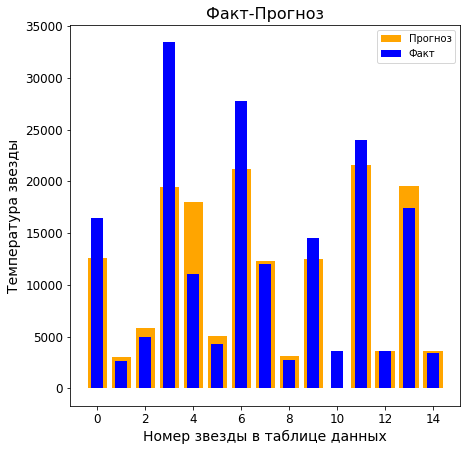

In [48]:
# Создание графика "Факт-Прогноз" по полученным результатам нейросети
show_graph(dropout_nn_preds)

Метрика RMSE достигла значения около 4 500,но порог не проходит.

Параметры модели на данном этапе:
- Использование батчей;
- "Выключение" части нейронов на каждом слое с помощью *Dropout*;
- Общее количество эпох - 15 001; 
- Тестирование модели - каждые 1 000.

<a name='conclusion'></a>
## 6. Выводы
[Введение](#introduction)

Всего было протестировано 4 модели нейронной сети (выводы по каждой модели с графиком по ссылке):
1. [Базовая неройсеть](#basic_nn);
2. [Нейросеть с использованием батчей](#batch_usage);
3. [Нейросеть с нормализацией батчей](#batch_norm);
4. [Нейросеть с "выключением" нейронов - *Dropout*](#dropout).

<br>Некоторые параметры модели были идентичны для повышения интерпретабельности влияния изменений на конечную метрику - *RMSE*:
1. Количество слоев и нейронов на каждом уровне:
    - Количество входных нейронов - 17 (по количеству параметров);
    - 1 скрытый слой - 8 нейронов;
    - 2 скрытый слой - 5 нейронов;
    - Количество выходных нейронов - 1.

<br>Наилучший показатель по метрике *RMSE* - около 4 000 - продемонстрировала **нейросеть с использованием нормализации батчей** со следующими параметрами:
- Использование батчей;
- Нормализация батчей с помощью *nn.BatchNorm1d()*;
- Общее количество эпох - 5 001;
- Тестирование модели - каждый 500 эпох.

<br>Также необходимый порог в 4 500 RMSE был пройден и **базовой нейронной сетью** и составил около 4 350. Параметры модели:
- Общее количество эпох - 10 001;
- Тестирование модели - каждые 1 000;
- Значение RMSE - около 4 350.

<br>Продемонстрируем график двух лучших моделей:


Нейросеть с нормализацией батчей:


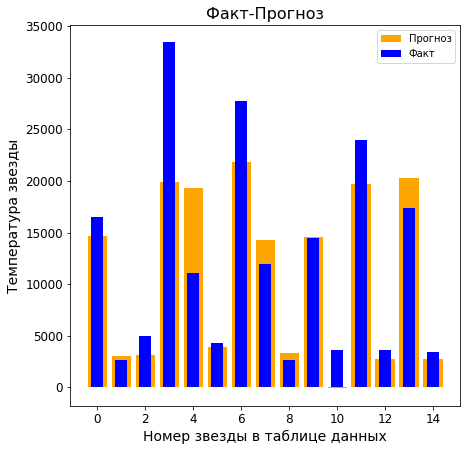

Базовая нейронная сеть:


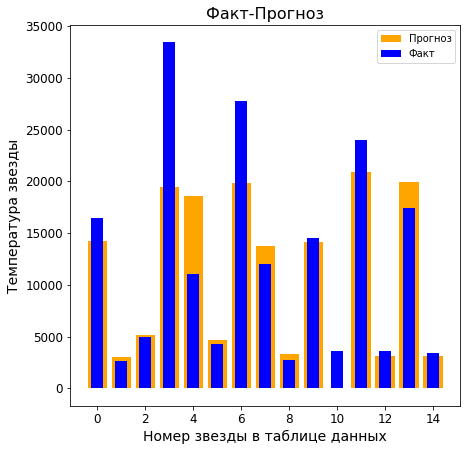

In [50]:
print('\nНейросеть с нормализацией батчей:')
show_graph(batch_norm_nn_preds)

print('Базовая нейронная сеть:')
show_graph(basic_nn_preds)

<h3>Рекомендация:</h3>

Рекомендуется использовать **нейросеть с использованием нормализации батчей**, поскольку ее метрика ниже, а ресурсы на обучение и тестирование не столь значительны в отличие от **базовой нейронной сети**.